In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy.ndimage import gaussian_filter1d

In [2]:
# read files
df_sentiment = pd.read_pickle("../data/cleaned/by_id_verified_sentiment_2020-2021.pkl")
df_tweet = pd.read_pickle("../data/cleaned/tweets_verified_2020-2021_cleaned.pkl")
df_bitcoin = pd.read_csv("../data/raw/bitcoin_value_2020-2021.csv", parse_dates=["datetime"])

# get differential of bitcoin value
df_bitcoin['diff'] = df_bitcoin['close_bitcoin'].diff()

In [3]:
# merge tweets and sentiment values
df_tweet_sentiment = pd.merge(df_tweet, df_sentiment, on='id')

# sum metrics
df_tweet_sentiment['sum_metrics'] = df_tweet_sentiment['replies_count'] + \
                                    df_tweet_sentiment['retweets_count'] + \
                                    df_tweet_sentiment['likes_count']

# get weights
df_freq = df_tweet_sentiment.groupby(['sum_metrics']).agg({'id':'count'}).reset_index()
df_freq = df_freq.rename(columns={'id': 'freq_tweets'})

freq_max = df_freq['freq_tweets'].max()
freq_min = df_freq['freq_tweets'].min()

df_freq['freq_tweets_norm'] = (df_freq['freq_tweets'] - freq_min) / (freq_max - freq_min)
df_freq['weights'] = 1 - df_freq['freq_tweets_norm']

display(df_freq)

,sum_metrics,freq_tweets,freq_tweets_norm,weights
0,0,28660,1.000000,0.000000
1,1,26524,0.925468,0.074532
2,2,20857,0.727730,0.272270
3,3,15447,0.538958,0.461042
4,4,12001,0.418717,0.581283
...,...,...,...,...
7429,322701,1,0.000000,1.000000
7430,384178,1,0.000000,1.000000
7431,688122,1,0.000000,1.000000
7432,1010436,1,0.000000,1.000000


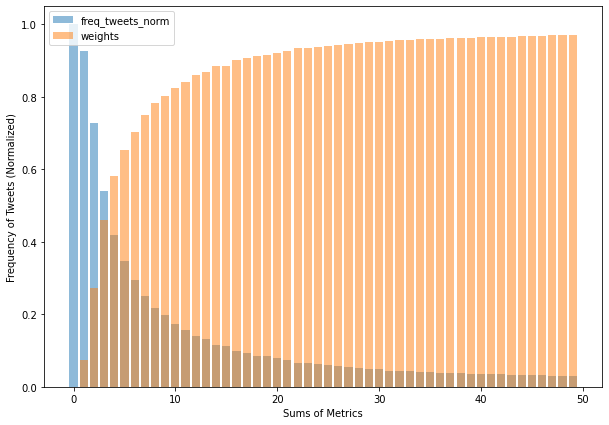

In [4]:
_ = plt.figure(figsize=(10, 7))

_ = plt.bar(df_freq['sum_metrics'][0:50], df_freq['freq_tweets_norm'][0:50], label='freq_tweets_norm', alpha=0.5)
_ = plt.bar(df_freq['sum_metrics'][0:50], df_freq['weights'][0:50], label='weights', alpha=0.5)

_ = plt.legend()
_ = plt.xlabel("Sums of Metrics")
_ = plt.ylabel("Frequency of Tweets (Normalized)")

_ = plt.savefig("figures/sum_metr_vs_freq.svg", format='svg')
_ = plt.show()

In [5]:
# merge weights with 
df = pd.merge(df_tweet_sentiment,\
              df_freq[['sum_metrics', 'weights']], \
              how='left', \
              on='sum_metrics')

# get weighted sentiments
df['weighted_sentiment'] = df['sentiment'] * df['weights']

display(df[['sentiment', 'sum_metrics', 'weights', 'weighted_sentiment']].head())

,sentiment,sum_metrics,weights,weighted_sentiment
0,-0.6249,433,0.998395,-0.623897
1,0.4329,10,0.825674,0.357434
2,0.1027,4,0.581283,0.059698
3,0.9482,185,0.994138,0.942642
4,-0.5106,0,0.000000,-0.000000


In [6]:
# group by date and get the mean of weighted_sentiment
df_by_date = df.groupby(df['created_at'].dt.date).agg({'weighted_sentiment': 'mean'}).reset_index()

display(df_by_date.head())

,created_at,weighted_sentiment
0,2020-01-01,0.126772
1,2020-01-02,0.073418
2,2020-01-03,0.145800
3,2020-01-04,0.087736
4,2020-01-05,0.057072


In [7]:
# clean data before export
df_by_date["created_at"] = pd.to_datetime(df_by_date["created_at"])
df_freq = df_freq.rename(columns={'created_at': 'datetime'})

# export as pickle
df_by_date.to_pickle("../data/cleaned/by_date_verified_weighted_sentiment_2020-2021.pkl")

In [8]:
# try reading pickle
df_test = pd.read_pickle("../data/cleaned/by_date_verified_weighted_sentiment_2020-2021.pkl")

display(df_test.dtypes)
display(df_test.head())

created_at            datetime64[ns]
weighted_sentiment           float64
dtype: object

,created_at,weighted_sentiment
0,2020-01-01,0.126772
1,2020-01-02,0.073418
2,2020-01-03,0.145800
3,2020-01-04,0.087736
4,2020-01-05,0.057072


In [9]:
def plot_sent_vs_bit(from_date, to_date, sigma, save_to=None):
    fig, ax1 = plt.subplots(figsize=(10, 7))

    _ = ax1.set_xlabel("Time (Month)")
    lns1 = ax1.plot(df_by_date['created_at'],
                    gaussian_filter1d(df_by_date['weighted_sentiment'], sigma), 
                    color='blue',
                    label='Weight Sentiment')
    _ = ax1.set_ylabel("Weighted Sentiment")

    ax2 = ax1.twinx()
    lns2 = ax2.plot(df_bitcoin['datetime'],
                    gaussian_filter1d(df_bitcoin['diff'], sigma),
                    color='orange',
                    label='Diff. Bitcoin')
    _ = ax2.set_ylabel("Diff. Bitcoin Value (Dollar)")

    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    _ = ax1.legend(lns, labs, loc=3)
    _ = ax1.set_xlim(pd.Timestamp(from_date), pd.Timestamp(to_date))

    if save_to is not None:
        _ = plt.savefig(save_to, format='svg')
    _ = plt.show()

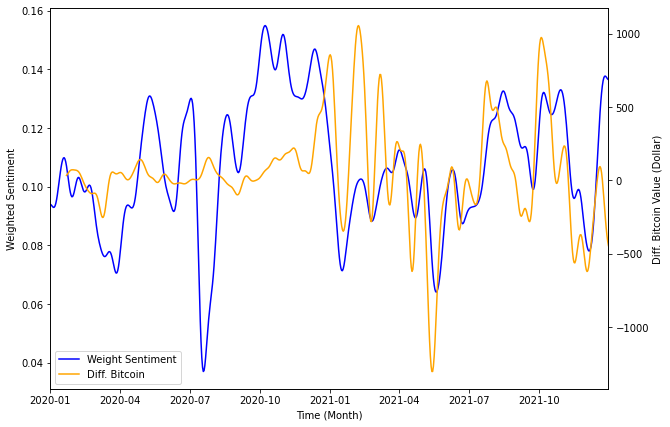

In [10]:
# plot weighted sentiment vs diff. bitcoin value
plot_sent_vs_bit('2020-01-01', '2021-12-31', 5)

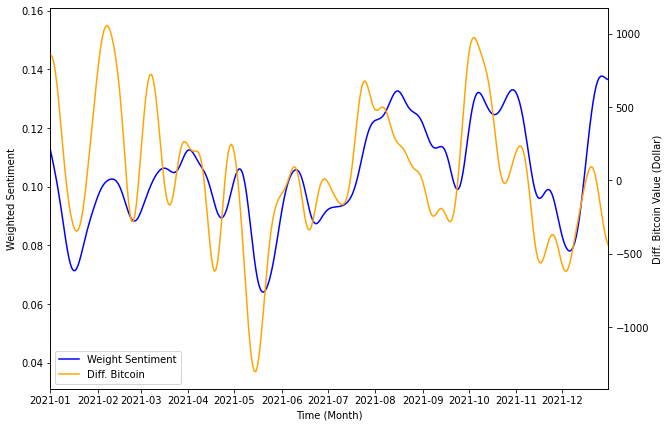

In [11]:
# plot weighted sentiment vs diff. bitcoin value (2021 only)
plot_sent_vs_bit('2021-01-01', '2021-12-31', 5)